# CIL-35208 Dataset
1. The dataset was first segmented with Cellpose's Cyto default model with an expected diameter set to 8.
2. Then, the masks for each image frame were put into .mat files with the keys labels and image.
3. `CellTrack_DL.m` was used to generate the morphological data from the segmentation data.
4. SVM was used to determine the phenotype from the morphological data.

Individual deep cells migrating by blebbing and lamellipodial activity in a fundulus heteroclitus (killifish) embryo

In [1]:
CIL_BASE_DIRECTORY = "../../CIL_35208/"

# Runtime Parameters

In [2]:
SAVE_EXTRAS = False

In [3]:
g_Base = lambda *args: DIR_ROOT + "Figures/CIL/35208/"

# Imports and Functions

In [4]:
from sunlab.environment.base.cpu import *
from sunlab.environment.base.extras import *
from sunlab.globals import FILES
from sunlab.sunflow import *

In [5]:
from sunlab.svm import *

In [6]:
import seaborn as sns

# SVM - Onnx Reserialization

In [7]:
import pandas as pd
data_fpath = f"{CIL_BASE_DIRECTORY}svm/CIL_35208.csv"
df = pd.read_csv(data_fpath)

data_columns = ['Area',
 'MjrAxisLength',
 'MnrAxisLength',
 'Eccentricity',
 'ConvexArea',
 'EquivDiameter',
 'Solidity',
 'Extent',
 'Perimeter',
 'ConvexPerim',
 'FibLen',
 'InscribeR',
 'BlebLen']

dataset = df[data_columns].to_numpy()

magnification = (10*15/20) # Estimate magnification from cell diameters as magnification was not given
pixel2dist = 1.075268 * 10/magnification

In [8]:
svm_scaler, svm_clf = svm_load(FILES['SVM']['ONNX']['SCALER'], FILES['SVM']['ONNX']['MODEL'])

In [9]:
classification = svm_infer(dataset, pixel2dist=pixel2dist, scaler_model=svm_scaler, clf_model=svm_clf)

In [10]:
df[['ActinEdge', 'Filopodia', 'Bleb', 'Lamellipodia']] = classification

In [11]:
df['Class'] = np.argmax(classification, axis=-1)

In [12]:
df.to_csv(f"{CIL_BASE_DIRECTORY}CIL_35208.csv")

# Setup

In [13]:
model = load_aae(FILES['PRETRAINED_MODEL_DIR'], MaxAbsScaler)

In [14]:
training_data = process_and_load_dataset(FILES['TRAINING_DATASET'], FILES['PRETRAINED_MODEL_DIR'])

In [15]:
from scipy.io import loadmat

In [16]:
cil_35208_dataset = process_and_load_dataset(f"{CIL_BASE_DIRECTORY}CIL_35208.csv", FILES['PRETRAINED_MODEL_DIR'], magnification=10*15/20)

In [17]:
frame = 1
labels = loadmat(f'{CIL_BASE_DIRECTORY}detections/CIL_35208_ut_{frame-1}.mat')['labels']
label_data = np.zeros((len(cil_35208_dataset.dataframe['Frames'].unique()),labels.shape[0],labels.shape[1]))
for frame in cil_35208_dataset.dataframe['Frames'].unique():
    labels = loadmat(f'{CIL_BASE_DIRECTORY}detections/CIL_35208_ut_{frame-1}.mat')['labels']
    label_data[frame-1,...] = labels

In [18]:
errors = np.mean(np.abs(cil_35208_dataset.dataset - model.autoencoder(cil_35208_dataset.dataset).numpy()), -1)
errors.mean().round(3),errors.std().round(3),errors.max().round(3)

(0.026, 0.012, 0.093)

# Plots - Unfiltered Data

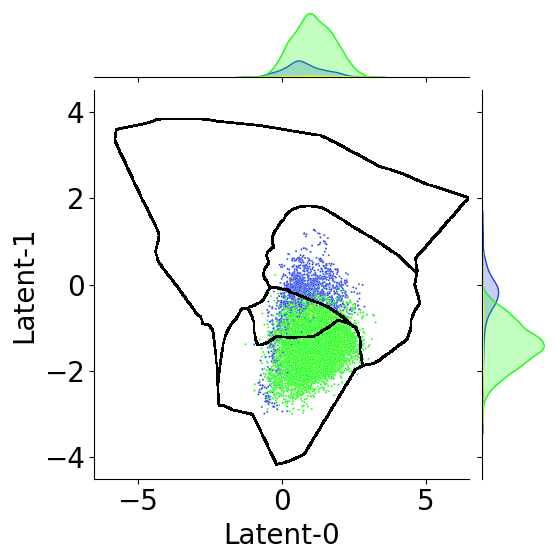

In [19]:
sns.jointplot(cil_35208_dataset.dataframe, x='Latent-0', y='Latent-1', hue='Class', s=2, palette=Pmap)
plt.gca().get_legend().remove()
plt.apply_boundary()
if SAVE_EXTRAS:
    plt.save(g_Base() + "Scatter")

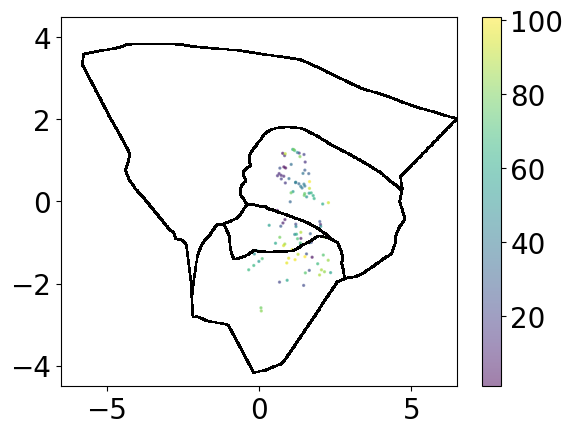

In [20]:
temporary_df = cil_35208_dataset.dataframe.copy()
temporary_df = temporary_df[temporary_df['CellNum'] == 1]
plt.scatter(temporary_df['Latent-0'], temporary_df['Latent-1'], c=temporary_df['Frames'], s=2, alpha=0.5)
plt.colorbar()
plt.apply_boundary()
if SAVE_EXTRAS:
    plt.save(g_Base() + "Scatter")

In [21]:
temporary_df

,Unnamed: 0,Frames,CellNum,Area,CentroidX,CentroidY,MjrAxisLength,MnrAxisLength,Eccentricity,Orientation,...,BlebLen,CenterX,CenterY,ActinEdge,Filopodia,Bleb,Lamellipodia,Class,Latent-0,Latent-1
0,0,1,1,617,27.337115,10.758509,42.604768,21.383211,0.864927,-6.387143,...,18.485281,32,12,3.127909e-08,3.045794e-08,2.741335e-08,1.000000,3,0.872829,0.817249
1,1,2,1,622,27.284566,10.782958,43.516999,21.421675,0.870448,-6.659915,...,19.656855,33,12,2.166835e-09,2.122277e-09,1.808179e-09,1.000000,3,0.816357,0.842770
2,2,3,1,856,34.514019,12.953271,55.566433,21.032464,0.925597,-14.640466,...,24.899494,39,14,1.091491e-06,1.767024e-05,6.754068e-04,0.999306,3,0.777053,1.174446
3,3,4,1,133,195.045113,8.105263,13.999709,12.405383,0.463461,-1.862654,...,2.414214,195,8,9.852600e-03,6.518186e-06,9.899544e-01,0.000187,2,1.743051,-1.359188
4,4,5,1,235,17.800000,19.991489,23.390775,13.178453,0.826182,-18.750360,...,8.071068,19,20,4.535594e-03,1.481588e-04,3.820084e-01,0.613308,3,0.598520,-0.218296
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,96,97,1,149,250.382550,15.744966,16.339092,11.825199,0.690076,28.324055,...,2.414214,250,15,4.428553e-03,5.228740e-07,9.954304e-01,0.000140,2,0.911474,-1.499096
97,97,98,1,179,250.262570,16.709497,16.723144,13.819750,0.563106,29.405464,...,3.000000,251,16,9.234284e-03,3.322389e-06,9.906039e-01,0.000158,2,1.539872,-1.020537
98,98,99,1,159,250.754717,16.522013,16.258159,12.660442,0.627380,15.525273,...,0.000000,251,16,5.050796e-02,3.474618e-06,9.494326e-01,0.000056,2,1.182809,-1.419615
99,99,100,1,628,86.127389,14.328025,37.057905,22.767357,0.789016,-9.857137,...,12.313707,86,13,1.203808e-06,1.305656e-06,1.422278e-03,0.998575,3,1.658242,0.484369


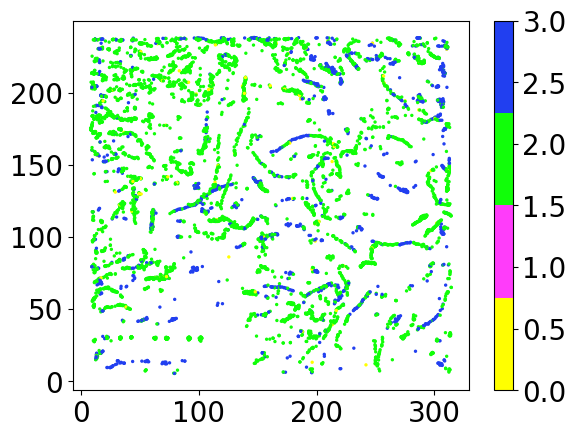

In [22]:
temporary_df = cil_35208_dataset.dataframe.copy()
# temporary_df = temporary_df[temporary_df['CellNum'] == 1]
plt.scatter(temporary_df['CentroidX'], temporary_df['CentroidY'], c=temporary_df['Class'], s=2, cmap=Pmap)
plt.colorbar()
# plt.apply_boundary()
if SAVE_EXTRAS:
    plt.save(g_Base() + "Scatter")

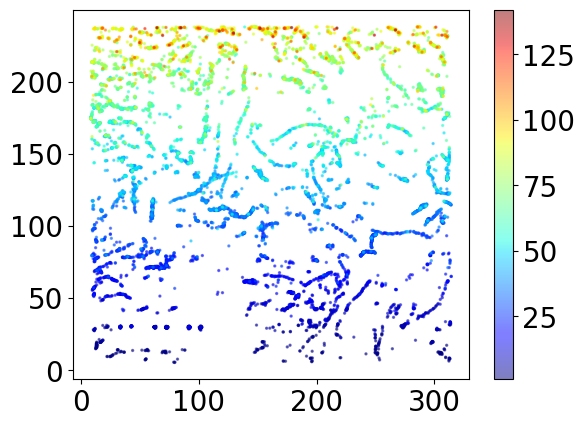

In [23]:
temporary_df = cil_35208_dataset.dataframe.copy()
# temporary_df = temporary_df[temporary_df['CellNum'] == 1]
plt.scatter(temporary_df['CentroidX'], temporary_df['CentroidY'], c=temporary_df['CellNum'], s=2, alpha=0.5, cmap='jet')
plt.colorbar()
# plt.apply_boundary()
if SAVE_EXTRAS:
    plt.save(g_Base() + "Scatter")

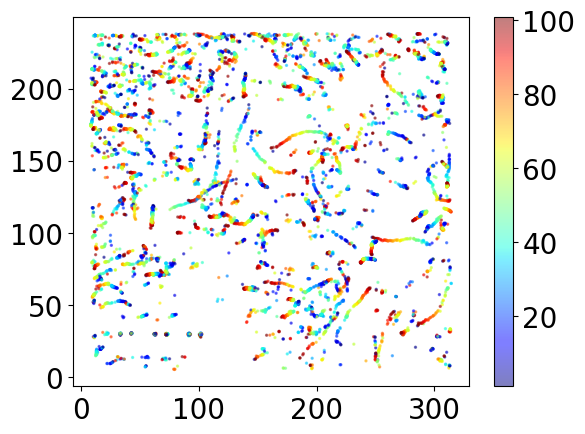

In [24]:
temporary_df = cil_35208_dataset.dataframe.copy()
# temporary_df = temporary_df[temporary_df['CellNum'] == 1]
plt.scatter(temporary_df['CentroidX'], temporary_df['CentroidY'], c=temporary_df['Frames'], s=2, alpha=0.5, cmap='jet')
plt.colorbar()
# plt.apply_boundary()
if SAVE_EXTRAS:
    plt.save(g_Base() + "Scatter")

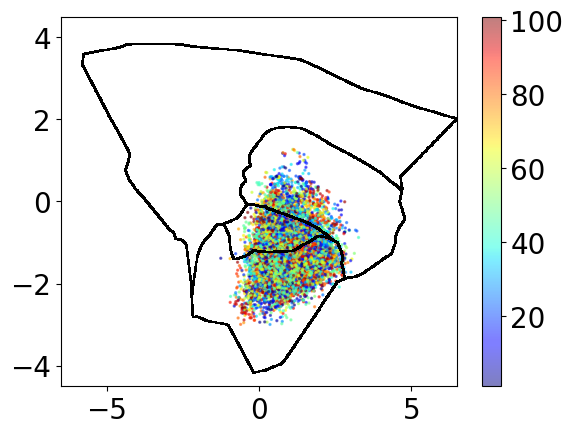

In [25]:
plt.scatter(cil_35208_dataset.dataframe['Latent-0'], cil_35208_dataset.dataframe['Latent-1'], c=cil_35208_dataset.dataframe['Frames'], s=2, alpha=0.5, cmap='jet')
plt.colorbar()
plt.apply_boundary()
if SAVE_EXTRAS:
    plt.save(g_Base() + "Scatter")

# Plots - Filter Data to Coherent Trajectories

In [26]:
from tqdm.auto import tqdm

In [27]:
sequence_tracker_data = []
df = cil_35208_dataset.dataframe.copy()
_THRESHOLD = 8
MIN_SEQUENCE = 30
breaking_distances = []
registered_nodes = set()
for REFERENCE_FRAME in tqdm(np.unique(df['Frames'])):
    base_frame = df[df['Frames'] == REFERENCE_FRAME].copy()
    for i in np.unique(base_frame['CellNum']):
        sequence_tracker_data_partial = [(REFERENCE_FRAME,i, 0),]
        current_position = base_frame[base_frame['CellNum'] == i][['CentroidX','CentroidY']].to_numpy()
        for frame in sorted(np.unique(df['Frames'])):
            if frame <= REFERENCE_FRAME:
                continue
            current_frame = df[df['Frames'] == frame]
            cns = current_frame['CellNum'].to_numpy()
            positions = current_frame[['CentroidX','CentroidY']].to_numpy()
            rel_positions = positions - current_position
            distances = np.linalg.norm(rel_positions, axis=-1)
            min_distance_arg = np.argmin(distances)
            assert min_distance_arg < distances.shape[0]
            assert min_distance_arg < positions.shape[0]
            assert min_distance_arg < cns.shape[0]
            assert distances.shape[0] == cns.shape[0]
            min_distance = np.min(distances)
            if min_distance > _THRESHOLD:
                breaking_distances.append(min_distance)
                continue
#                 break
            cn = cns[min_distance_arg]
            if (frame,cn) in registered_nodes:
                break
            registered_nodes |= {(frame,cn)}
            sequence_tracker_data_partial.append((frame,cn,min_distance))
            current_position = positions[min_distance_arg,...]
        if len(sequence_tracker_data_partial) >= MIN_SEQUENCE:
            sequence_tracker_data.append(sequence_tracker_data_partial)
sequence_tracker_data[0]

  0%|          | 0/101 [00:00<?, ?it/s]

[(1, 5, 0),
 (2, 8, 0.1638267665532942),
 (5, 3, 3.8786338944580945),
 (6, 3, 0.30597158227492705),
 (9, 2, 0.5977614403951735),
 (10, 7, 1.0025471267043056),
 (11, 5, 0.9403051210778809),
 (12, 4, 0.7429835841433383),
 (14, 5, 1.9252777689796288),
 (18, 1, 5.3390293677163525),
 (20, 2, 1.8527686040992428),
 (22, 3, 1.327413356460569),
 (23, 5, 0.3694978249021877),
 (24, 6, 1.176892225424552),
 (26, 7, 0.363415881696053),
 (27, 6, 0.17285922357028194),
 (28, 6, 0.2486354236049112),
 (31, 10, 3.0078353905414326),
 (32, 8, 0.6992463126457535),
 (37, 9, 6.866166936943081),
 (42, 8, 2.780707049450484),
 (43, 11, 0.5865142847584559),
 (44, 10, 0.43585111877181365),
 (45, 7, 0.2947987027673524),
 (46, 8, 0.2348690590761969),
 (48, 8, 0.2981457783540071),
 (49, 7, 1.7813528652149138),
 (50, 7, 1.0390041308164588),
 (51, 5, 0.7047693301473474),
 (52, 6, 0.8295069306922955),
 (53, 10, 0.21341593478714238),
 (54, 9, 1.4441690928430524),
 (55, 10, 0.5554690055364969),
 (56, 8, 3.742393308645696),

(array([1.8329e+04, 9.2540e+03, 3.5520e+03, 1.0890e+03, 3.3700e+02,
        8.9000e+01, 4.8000e+01, 4.6000e+01, 3.3000e+01, 7.0000e+00]),
 array([ 8.00486079, 17.08902498, 26.17318916, 35.25735335, 44.34151754,
        53.42568172, 62.50984591, 71.5940101 , 80.67817428, 89.76233847,
        98.84650265]),
 <BarContainer object of 10 artists>)

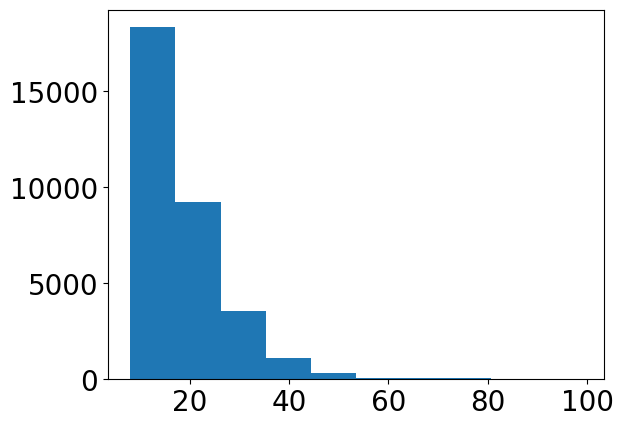

In [28]:
plt.hist(breaking_distances)

In [29]:
len(sequence_tracker_data)

101

(array([ 6., 12., 15., 17., 20., 11.,  9.,  6.,  3.,  2.]),
 array([ 17.15942291,  29.01271286,  40.8660028 ,  52.71929275,
         64.5725827 ,  76.42587265,  88.2791626 , 100.13245254,
        111.98574249, 123.83903244, 135.69232239]),
 <BarContainer object of 10 artists>)

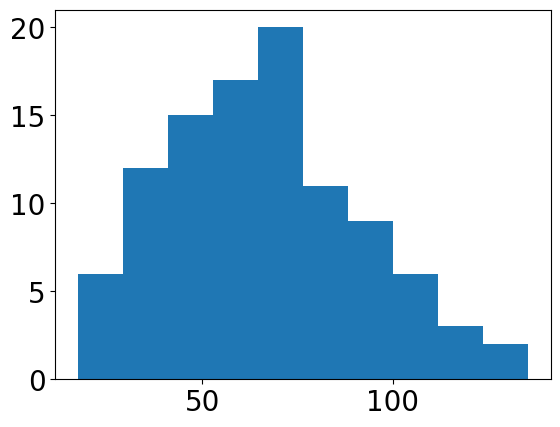

In [30]:
plt.hist([sum([i for _,_,i in s]) for s in sequence_tracker_data])

(array([25., 14., 14.,  7.,  7., 13.,  5.,  6.,  5.,  5.]),
 array([ 30. ,  37.1,  44.2,  51.3,  58.4,  65.5,  72.6,  79.7,  86.8,
         93.9, 101. ]),
 <BarContainer object of 10 artists>)

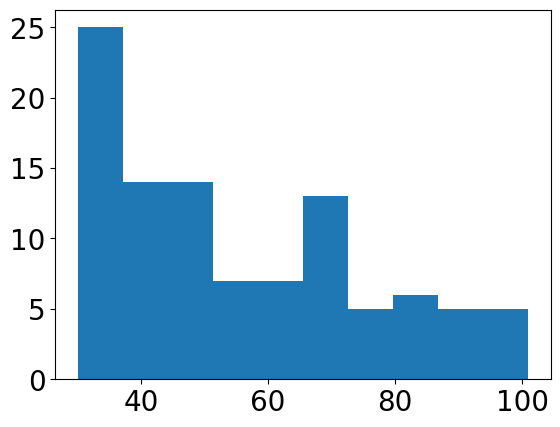

In [31]:
plt.hist([len(s) for s in sequence_tracker_data])

In [32]:
sequence_tracker_data

[[(1, 5, 0),
  (2, 8, 0.1638267665532942),
  (5, 3, 3.8786338944580945),
  (6, 3, 0.30597158227492705),
  (9, 2, 0.5977614403951735),
  (10, 7, 1.0025471267043056),
  (11, 5, 0.9403051210778809),
  (12, 4, 0.7429835841433383),
  (14, 5, 1.9252777689796288),
  (18, 1, 5.3390293677163525),
  (20, 2, 1.8527686040992428),
  (22, 3, 1.327413356460569),
  (23, 5, 0.3694978249021877),
  (24, 6, 1.176892225424552),
  (26, 7, 0.363415881696053),
  (27, 6, 0.17285922357028194),
  (28, 6, 0.2486354236049112),
  (31, 10, 3.0078353905414326),
  (32, 8, 0.6992463126457535),
  (37, 9, 6.866166936943081),
  (42, 8, 2.780707049450484),
  (43, 11, 0.5865142847584559),
  (44, 10, 0.43585111877181365),
  (45, 7, 0.2947987027673524),
  (46, 8, 0.2348690590761969),
  (48, 8, 0.2981457783540071),
  (49, 7, 1.7813528652149138),
  (50, 7, 1.0390041308164588),
  (51, 5, 0.7047693301473474),
  (52, 6, 0.8295069306922955),
  (53, 10, 0.21341593478714238),
  (54, 9, 1.4441690928430524),
  (55, 10, 0.55546900553649

In [33]:
data_columns = ['Area', 'CentroidX', 'CentroidY',
       'MjrAxisLength', 'MnrAxisLength', 'Eccentricity', 'Orientation',
       'ConvexArea', 'FilledArea', 'EquivDiameter', 'Solidity', 'Extent',
       'Perimeter', 'PerimOld', 'ConvexPerim', 'FibLen', 'InscribeR',
       'BlebLen', 'CenterX', 'CenterY', 'ActinEdge', 'Filopodia', 'Bleb',
       'Lamellipodia', 'Class', 'Latent-0', 'Latent-1']
sequence_df = pd.DataFrame(columns=['Frames', 'CellNum', ] + data_columns)
sequence_df

,Frames,CellNum,Area,CentroidX,CentroidY,MjrAxisLength,MnrAxisLength,Eccentricity,Orientation,ConvexArea,...,BlebLen,CenterX,CenterY,ActinEdge,Filopodia,Bleb,Lamellipodia,Class,Latent-0,Latent-1


In [34]:
displacements = [sum([i for _,_,i in s]) for s in sequence_tracker_data]
ndisplacements = [sum([i for _,_,i in s])/len(s) for s in sequence_tracker_data]

In [35]:
DISPACEMENT_THRESHOLD = 75
NDISPACEMENT_THRESHOLD = 0

In [36]:
index = 0
for CELL_NUM,sequence in tqdm(enumerate(sequence_tracker_data)):
    if displacements[CELL_NUM] < DISPACEMENT_THRESHOLD:
        continue
    if ndisplacements[CELL_NUM] < NDISPACEMENT_THRESHOLD:
        continue
    for frame, cn, _distance in sequence:
        sequence_df.loc[index] = [frame, CELL_NUM,] + df[(df['Frames'] == frame)&(df['CellNum'] == cn)][data_columns].to_numpy().tolist()[0]
        index += 1
sequence_df

0it [00:00, ?it/s]

,Frames,CellNum,Area,CentroidX,CentroidY,MjrAxisLength,MnrAxisLength,Eccentricity,Orientation,ConvexArea,...,BlebLen,CenterX,CenterY,ActinEdge,Filopodia,Bleb,Lamellipodia,Class,Latent-0,Latent-1
0,1.0,0.0,175.0,220.520000,22.702857,17.113649,13.270127,0.631456,82.422574,177.0,...,2.414214,220.0,23.0,1.488414e-06,5.071871e-07,0.999956,0.000042,2.0,1.365928,-1.341334
1,2.0,0.0,157.0,220.547771,22.541401,15.832820,12.786376,0.589749,80.832571,165.0,...,3.414214,220.0,22.0,2.884347e-03,2.442072e-06,0.996710,0.000403,2.0,1.381637,-1.335768
2,5.0,0.0,152.0,217.276316,24.625000,16.507429,12.037872,0.684258,40.711366,161.0,...,4.414214,217.0,24.0,1.627064e-03,8.530181e-06,0.996248,0.002116,2.0,0.819923,-1.201999
3,6.0,0.0,146.0,217.445205,24.369863,16.198134,11.761134,0.687611,33.121591,156.0,...,1.000000,218.0,24.0,7.436670e-02,1.323971e-05,0.925577,0.000044,2.0,0.868582,-1.492128
4,9.0,0.0,107.0,216.850467,24.429907,14.123897,10.080889,0.700404,20.668164,118.0,...,8.242640,217.0,24.0,4.877231e-02,7.634038e-06,0.950682,0.000538,2.0,0.405501,-1.426289
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2464,82.0,75.0,112.0,142.892857,42.500000,12.193667,11.919866,0.210724,57.331907,117.0,...,1.000000,143.0,43.0,7.162988e-03,1.640665e-06,0.992817,0.000019,2.0,2.569725,-1.654639
2465,83.0,75.0,101.0,142.415842,43.079208,11.686151,11.163311,0.295768,-86.440291,103.0,...,1.000000,142.0,43.0,8.365176e-07,2.958951e-07,0.999998,0.000001,2.0,2.345706,-1.948437
2466,84.0,75.0,127.0,141.937008,42.196850,13.560441,12.105311,0.450665,-86.789737,131.0,...,1.414214,142.0,42.0,5.123542e-03,6.387316e-07,0.994862,0.000014,2.0,1.906992,-1.761297
2467,89.0,75.0,129.0,140.976744,38.488372,13.944750,11.947486,0.515694,-87.459206,136.0,...,1.414214,141.0,38.0,5.310567e-02,4.196327e-06,0.946886,0.000005,2.0,1.478923,-1.594221


# Filtered Data Processing

In [37]:
from glob import glob
image_list = sorted(glob(f"{CIL_BASE_DIRECTORY}frames/out*png"), key=lambda x: int(x[len(f"{CIL_BASE_DIRECTORY}frames/out"):-4]))
img_stack = []
for image in image_list:
    img_stack.append(plt.imread(image))
img_stack = np.array(img_stack)

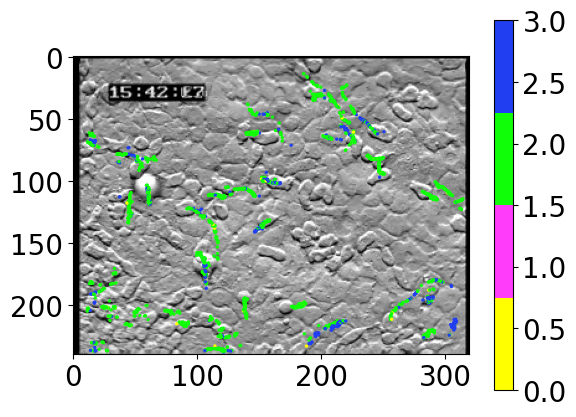

In [38]:
temporary_df = sequence_df.copy()
# temporary_df = temporary_df[temporary_df['CellNum'] == 1]
plt.imshow(img_stack[-1,...])
plt.scatter(temporary_df['CentroidX'], temporary_df['CentroidY'], c=temporary_df['Class'], s=2, cmap=Pmap)
plt.colorbar()
# plt.apply_boundary()
if SAVE_EXTRAS:
    plt.save(g_Base() + "Scatter")

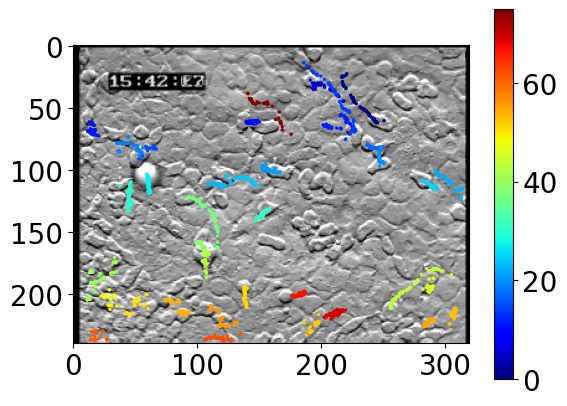

In [39]:
temporary_df = sequence_df.copy()
# temporary_df = temporary_df[temporary_df['CellNum'] == 1]
plt.imshow(img_stack[-1,...])
plt.scatter(temporary_df['CentroidX'], temporary_df['CentroidY'], c=temporary_df['CellNum'], s=2, cmap='jet')
plt.colorbar()
# plt.apply_boundary()
if SAVE_EXTRAS:
    plt.save(g_Base() + "Scatter")

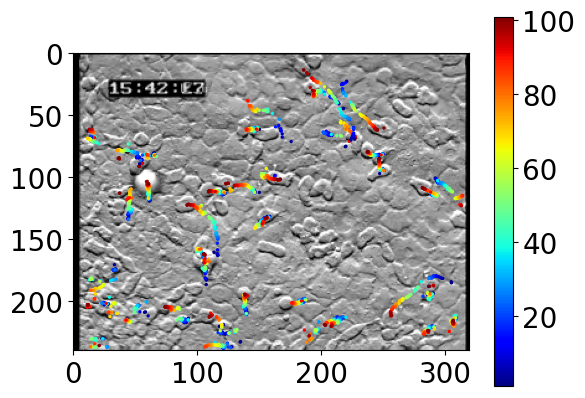

In [40]:
temporary_df = sequence_df.copy()
# temporary_df = temporary_df[temporary_df['CellNum'] == 1]
plt.imshow(img_stack[-1,...])
plt.scatter(temporary_df['CentroidX'], temporary_df['CentroidY'], c=temporary_df['Frames'], s=2, cmap='jet')
plt.colorbar()
# plt.apply_boundary()
if SAVE_EXTRAS:
    plt.save(g_Base() + "ImageTrack")

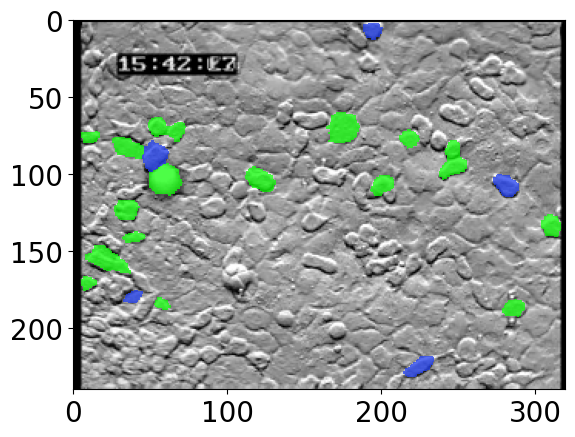

In [41]:
frame = label_data.shape[0]-1
temporary_df = sequence_df.copy()
temporary_df = temporary_df[temporary_df['Frames'] == frame+1]
image = img_stack[frame,...]
segmentation = label_data[frame, ...]
phenotype_segmentation = segmentation.copy().astype(np.int32)
phenotype_cn = set(np.unique(segmentation).tolist()) - {0,}
phenotype_segmentation[segmentation==0] = -1
for cell in temporary_df['CellNum'].unique():
    cell_num = cell+1
    phenotype_segmentation[segmentation==cell_num] = temporary_df[temporary_df['CellNum'] == cell]['Class'].iloc[0]
    phenotype_cn = phenotype_cn - {cell_num}
for cell in phenotype_cn:
    cell_num = cell+1
    phenotype_segmentation[segmentation==cell] = -1
phenotype_segmentation = np.ma.masked_equal(phenotype_segmentation, -1)

plt.imshow(img_stack[-1,...])
plt.imshow(phenotype_segmentation, cmap=Pmap, vmin=0, vmax=3, alpha=0.75)
if SAVE_EXTRAS:
    plt.save(g_Base() + "Image_Seg")

In [42]:
temporary_df = sequence_df.copy()

In [43]:
classification = temporary_df[['ActinEdge', 'Filopodia', 'Bleb', 'Lamellipodia']].to_numpy()
tclassification = np.argmax(np.hstack([classification, np.ones((classification.shape[0],1))*0.7]), axis=-1)

In [44]:
temporary_df['ClassT'] = tclassification

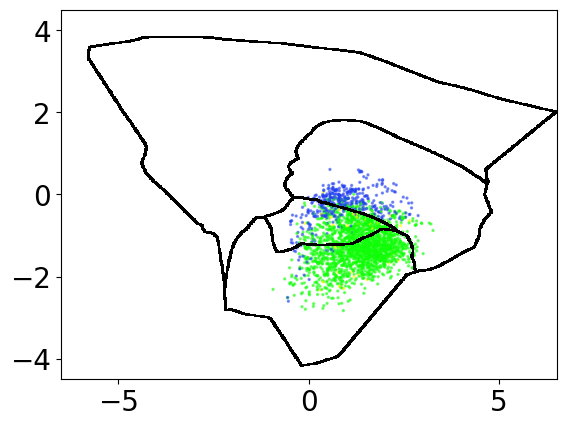

In [45]:
plt.scatter(temporary_df['Latent-0'], temporary_df['Latent-1'], c=temporary_df['Class'], s=2, alpha=0.5, cmap=Pmap)
# plt.colorbar()
plt.apply_boundary()
if SAVE_EXTRAS:
    plt.save(g_Base() + "Scatter")

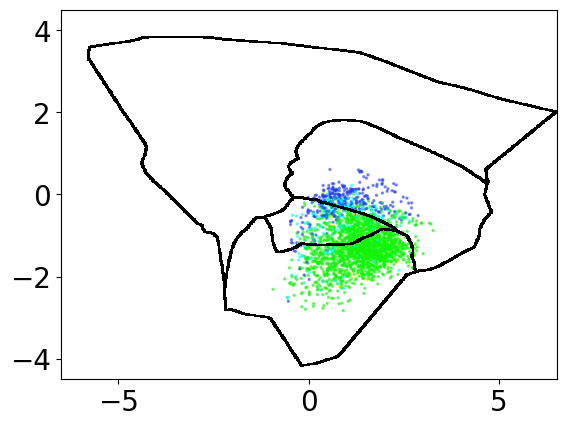

In [46]:
plt.scatter(temporary_df['Latent-0'], temporary_df['Latent-1'], c=tclassification, s=2, alpha=0.5, cmap=Pmapx)
plt.apply_boundary()
if SAVE_EXTRAS:
    plt.save(g_Base() + "Scatter")

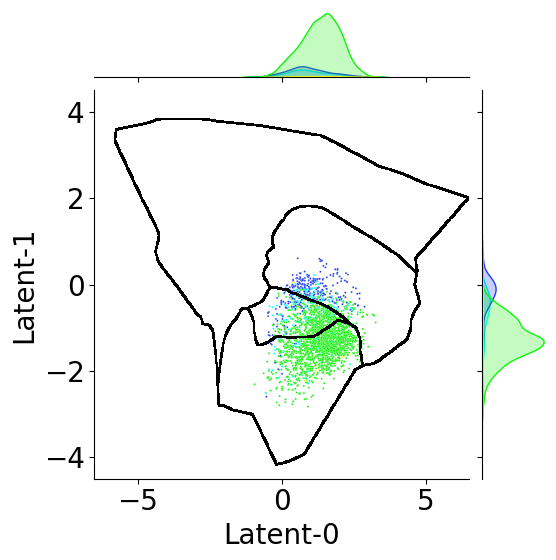

In [47]:
sns.jointplot(temporary_df, x='Latent-0', y='Latent-1', hue='ClassT', s=2, palette=Pmapx)
plt.gca().get_legend().remove()
plt.apply_boundary()
if SAVE_EXTRAS:
    plt.save(g_Base() + "Scatter")

In [48]:
sorted([(i,len(s),displacements[i]) for i,s in enumerate(sequence_tracker_data)], key=lambda x: x[2], reverse=True)

[(56, 60, 135.6923223857458),
 (69, 71, 128.8448158061172),
 (27, 98, 115.91979125553651),
 (12, 66, 114.9299738723574),
 (25, 101, 112.72564551881051),
 (37, 75, 111.9256418794521),
 (41, 69, 111.5218082179232),
 (23, 88, 110.83394067793395),
 (55, 87, 107.81781663121431),
 (53, 64, 103.173107845924),
 (48, 48, 100.92766193860783),
 (19, 58, 99.62608712475723),
 (10, 72, 99.47436105695948),
 (31, 77, 97.22162128173534),
 (14, 68, 94.12959404645217),
 (44, 68, 93.22820490239314),
 (20, 101, 92.29255313168336),
 (11, 49, 91.99993074111991),
 (43, 46, 91.68674976822957),
 (54, 63, 88.64311598625625),
 (5, 58, 87.50199670758099),
 (67, 85, 83.55795267250022),
 (0, 74, 83.20310399848519),
 (22, 85, 82.6632013317584),
 (62, 55, 82.50315273655457),
 (15, 43, 82.45485648476969),
 (46, 37, 80.80255718935585),
 (52, 33, 80.16901686564401),
 (51, 82, 80.05797566314648),
 (17, 97, 79.92764836407295),
 (30, 64, 77.5149346884744),
 (61, 30, 75.9499669283972),
 (39, 71, 75.90799201780081),
 (24, 97,

In [49]:
temporary_df

,Frames,CellNum,Area,CentroidX,CentroidY,MjrAxisLength,MnrAxisLength,Eccentricity,Orientation,ConvexArea,...,CenterX,CenterY,ActinEdge,Filopodia,Bleb,Lamellipodia,Class,Latent-0,Latent-1,ClassT
0,1.0,0.0,175.0,220.520000,22.702857,17.113649,13.270127,0.631456,82.422574,177.0,...,220.0,23.0,1.488414e-06,5.071871e-07,0.999956,0.000042,2.0,1.365928,-1.341334,2
1,2.0,0.0,157.0,220.547771,22.541401,15.832820,12.786376,0.589749,80.832571,165.0,...,220.0,22.0,2.884347e-03,2.442072e-06,0.996710,0.000403,2.0,1.381637,-1.335768,2
2,5.0,0.0,152.0,217.276316,24.625000,16.507429,12.037872,0.684258,40.711366,161.0,...,217.0,24.0,1.627064e-03,8.530181e-06,0.996248,0.002116,2.0,0.819923,-1.201999,2
3,6.0,0.0,146.0,217.445205,24.369863,16.198134,11.761134,0.687611,33.121591,156.0,...,218.0,24.0,7.436670e-02,1.323971e-05,0.925577,0.000044,2.0,0.868582,-1.492128,2
4,9.0,0.0,107.0,216.850467,24.429907,14.123897,10.080889,0.700404,20.668164,118.0,...,217.0,24.0,4.877231e-02,7.634038e-06,0.950682,0.000538,2.0,0.405501,-1.426289,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2464,82.0,75.0,112.0,142.892857,42.500000,12.193667,11.919866,0.210724,57.331907,117.0,...,143.0,43.0,7.162988e-03,1.640665e-06,0.992817,0.000019,2.0,2.569725,-1.654639,2
2465,83.0,75.0,101.0,142.415842,43.079208,11.686151,11.163311,0.295768,-86.440291,103.0,...,142.0,43.0,8.365176e-07,2.958951e-07,0.999998,0.000001,2.0,2.345706,-1.948437,2
2466,84.0,75.0,127.0,141.937008,42.196850,13.560441,12.105311,0.450665,-86.789737,131.0,...,142.0,42.0,5.123542e-03,6.387316e-07,0.994862,0.000014,2.0,1.906992,-1.761297,2
2467,89.0,75.0,129.0,140.976744,38.488372,13.944750,11.947486,0.515694,-87.459206,136.0,...,141.0,38.0,5.310567e-02,4.196327e-06,0.946886,0.000005,2.0,1.478923,-1.594221,2


In [50]:
data = {}
for cell_num in np.unique(temporary_df['CellNum']):
    ldf = temporary_df[temporary_df['CellNum'] == cell_num].copy()
    mf,Mf = ldf['Frames'].min(), ldf['Frames'].max()
    start = ldf[ldf['Frames'] == mf]
    end = ldf[ldf['Frames'] == Mf]
    ldf = ldf.sort_values('Frames')
    n_steps = 2
    def my_fun(x):
        return x.iloc[-1] - x.iloc[0]

    X = ldf['CentroidX'].to_numpy()
    Y = ldf['CentroidY'].to_numpy()
    XY = np.hstack([X[...,np.newaxis], Y[...,np.newaxis]])
    D = np.linalg.norm(XY[-1,...] - XY[0,...])
    dX = ldf['CentroidX'].rolling(window=n_steps).apply(my_fun).dropna().abs().to_numpy()
    dY = ldf['CentroidY'].rolling(window=n_steps).apply(my_fun).dropna().abs().to_numpy()
    dXY = np.linalg.norm(np.hstack([dX[...,np.newaxis], dY[...,np.newaxis]]), axis=-1)
    data[int(cell_num)] = {
        "displacement": np.sum(dXY),
        "distance": D,
        "length": X.shape[0],
        "min_distance": dXY.min(),
        "max_distance": dXY.max(),
    }

In [51]:
for row in [(x,*y.values()) for x,y in sorted(data.items(), key=lambda x: x[1]['distance'], reverse=True)]:
    print("%5i, %6.2f %6.2f %3i. %7.3f %6.2f" % row)

   14,  94.13  70.45  68.   0.114   7.84
   44,  93.23  54.90  68.   0.104   7.49
   75,  75.37  48.24  37.   0.146   7.98
    0,  83.20  48.14  74.   0.101   6.87
   37, 111.93  43.82  75.   0.167   7.10
   41, 111.52  37.08  69.   0.044   7.99
   22,  82.66  30.81  85.   0.064   7.79
   62,  82.50  29.14  55.   0.090   7.73
    5,  87.50  28.84  58.   0.039   7.71
   24,  75.37  28.11  97.   0.056   5.50
   30,  77.51  21.44  64.   0.092   7.73
   54,  88.64  21.06  63.   0.093   7.29
   52,  80.17  20.30  33.   0.137   7.43
   19,  99.63  18.57  58.   0.031   6.83
   12, 114.93  17.90  66.   0.050   7.97
   43,  91.69  17.69  46.   0.064   7.98
   50,  75.20  16.81  43.   0.008   7.99
   69, 128.84  16.50  71.   0.093   7.89
   51,  80.06  15.64  82.   0.048   7.32
   15,  82.45  15.60  43.   0.025   6.82
   27, 115.92  13.46  98.   0.062   7.50
   23, 110.83  12.69  88.   0.040   6.77
   17,  79.93  11.75  97.   0.029   7.81
   56, 135.69  11.14  60.   0.044   7.96
   20,  92.29   

In [52]:
ldf = temporary_df[temporary_df['CellNum'] == 14].copy()

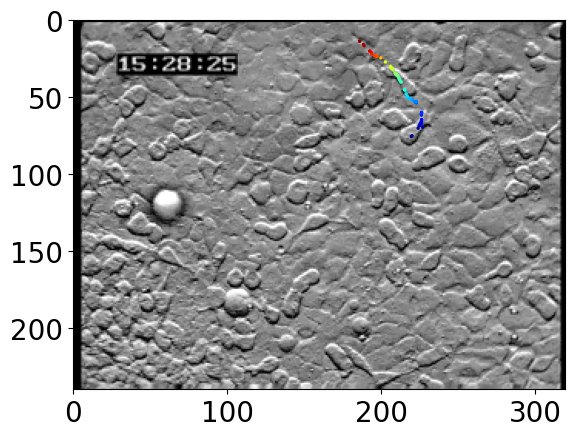

In [53]:
plt.imshow(img_stack[int(ldf['Frames'].min())-1,...])
plt.scatter(ldf['CentroidX'], ldf['CentroidY'], c=ldf['Frames'], s=2, cmap='jet')

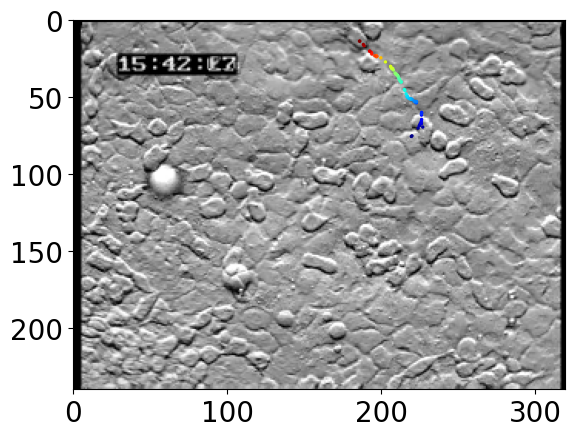

In [54]:
plt.imshow(img_stack[int(df['Frames'].max())-1,...])
plt.scatter(ldf['CentroidX'], ldf['CentroidY'], c=ldf['Frames'], s=2, cmap='jet')

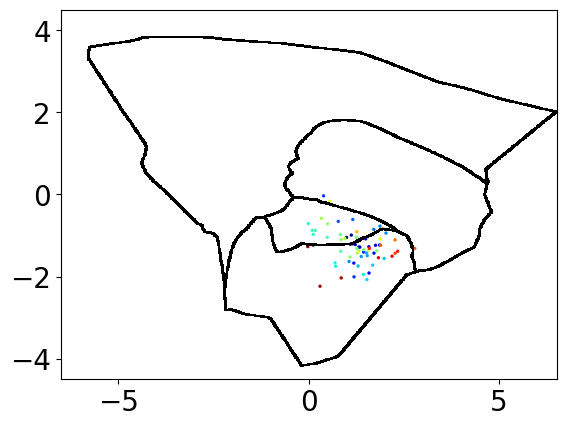

In [55]:
plt.scatter(ldf['Latent-0'], ldf['Latent-1'], c=ldf['Frames'], s=2, cmap='jet')
# plt.colorbar()
plt.apply_boundary()
if SAVE_EXTRAS:
    plt.save(g_Base() + "Scatter")

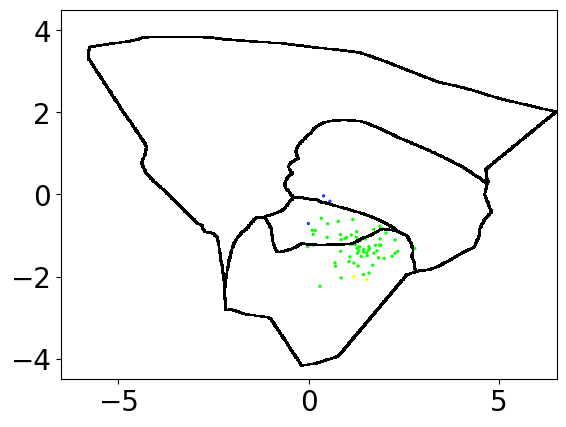

In [56]:
plt.scatter(ldf['Latent-0'], ldf['Latent-1'], c=ldf['Class'], s=2, cmap=Pmap)
# plt.colorbar()
plt.apply_boundary()
if SAVE_EXTRAS:
    plt.save(g_Base() + "Scatter")

# END